In [3]:
import torch
print("PyTorch version:", torch.__version__)
print(f'Apple Silicon Acceleration: {torch.backends.mps.is_available()}')

PyTorch version: 2.6.0.dev20241112
Apple Silicon Acceleration: True


### Common tensor operations

In [15]:
tensor2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(tensor2d)
print(tensor2d.shape)

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])


In [21]:
print('.reshape')
print(tensor2d.reshape(3,2))
print(tensor2d.reshape(3,2).shape)

#Similar to .reshape
print('\n.view')
print(tensor2d.view(3,2))

#And in this case transpose
print('\n.T')
print(tensor2d.T)

.reshape
tensor([[1, 2],
        [3, 4],
        [5, 6]])
torch.Size([3, 2])

.view
tensor([[1, 2],
        [3, 4],
        [5, 6]])

.T
tensor([[1, 4],
        [2, 5],
        [3, 6]])


### Matrix multiplication

In [22]:
print(tensor2d.matmul(tensor2d.T))

tensor([[14, 32],
        [32, 77]])


In [23]:
print(f'@')
print(tensor2d@tensor2d.T)

@
tensor([[14, 32],
        [32, 77]])


### Autograd

In [31]:
import torch.nn.functional as F
from torch.autograd import grad

y = torch.tensor([1.0])
x1 = torch.tensor([1.1])
w1 = torch.tensor([2.2], requires_grad=True)
b = torch.tensor([0.0], requires_grad=True)

# Forward pass
z = x1 * w1 + b
a = torch.sigmoid(z)
loss = F.binary_cross_entropy(a,y)

grad_L_w1 = grad(loss, w1, retain_graph=True)
grad_L_b = grad(loss, b, retain_graph=True)

In [28]:
print(grad_L_w1)
print(grad_L_b)

(tensor([-0.0898]),)
(tensor([-0.0817]),)


In [29]:
loss.backward()
print(w1.grad)
print(b.grad)

tensor([-0.0898])
tensor([-0.0817])


### NN modoule


In [32]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential( 

            # 1st hindden layer
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),

            # 2. hidden layer
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),

            # output
            torch.nn.Linear(20, num_outputs)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits 

In [33]:
model = NeuralNetwork(50,3)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)


In [45]:
# Weight of the first layer
print(model.layers[0].weight.size())

print(model.layers[0].weight)

torch.Size([30, 50])
Parameter containing:
tensor([[ 0.0298,  0.0267, -0.0238,  ..., -0.0856,  0.0228, -0.0602],
        [ 0.0385, -0.1363, -0.0456,  ..., -0.1268,  0.0309, -0.0857],
        [-0.0104, -0.0358,  0.1187,  ...,  0.0967, -0.1073, -0.0325],
        ...,
        [-0.0106,  0.0824, -0.0935,  ..., -0.0996,  0.0063,  0.0191],
        [ 0.0356, -0.0246,  0.0713,  ...,  0.0969, -0.0452,  0.0093],
        [-0.0003,  0.0216,  0.0315,  ..., -0.0412,  0.0567, -0.0936]],
       requires_grad=True)


In [46]:
X = torch.rand(1, 50)
out = model(X)
print(out)

tensor([[0.1021, 0.0474, 0.1976]], grad_fn=<AddmmBackward0>)


### Efficient Dataloaders
**Dataset** define how individual data is loaded

**DataLoader** define how datashet shuffling and batching is handled


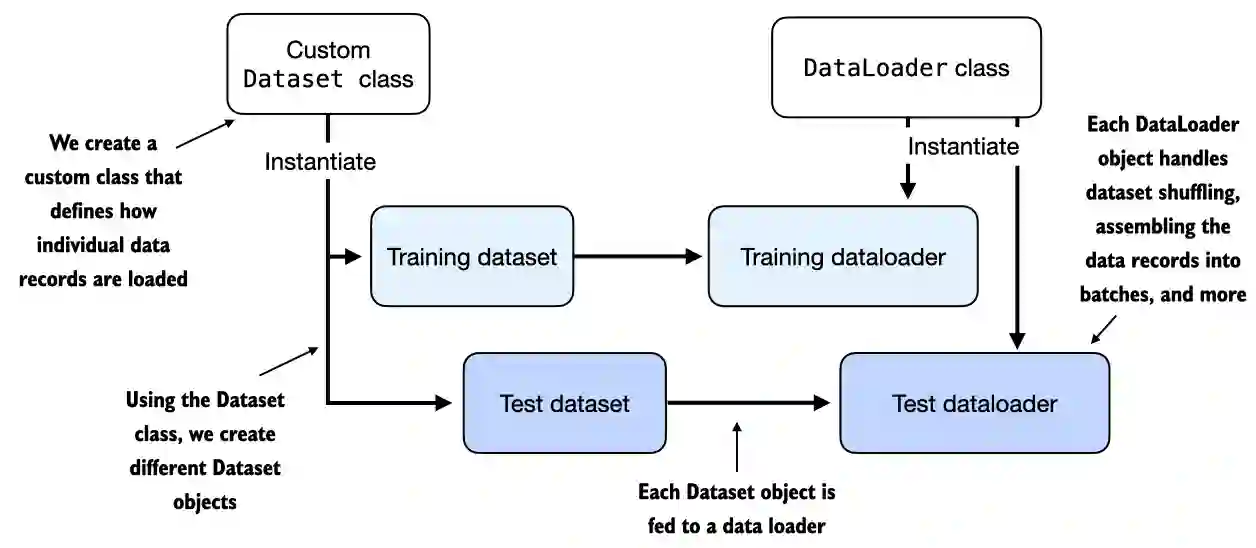 

In [47]:
X_train = torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [2.3, -1.1],
    [2.7, -1.5]
])

y_train = torch.tensor([0, 0, 0, 1, 1])

X_test = torch.tensor([
    [-0.8, 2.8],
    [2.6, -1.6],
])

y_test = torch.tensor([0, 1])

In [48]:
from torch.utils.data import Dataset

class ToyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        one_x = self.features[index]
        one_y = self.labels[index]
        return one_x, one_y
    
    def __len__(self):
        return self.labels.shape[0]

train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(X_test, y_test)

Setting up the Dataloader
- Having a significantly lower batch size (if training data sample size is not divisible by batch size) can disturb convergence during training.
- Setting **drop_last=True** drops the last batch to avoid this issue
- **num_works for notebooks!** > 0 can lead to problems of ressource sharing as notebooks are not handling multithreading well. For other scenarios, increase to speed up training by having multiple processes provide prepare data in the background and queue them up as to provide imidiately when a model training iteration has been executed.
- num_workers = 4 usually leads to optimal performance as per authors experience on real world datasets

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(42)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

In [51]:
for idx, (x,y) in enumerate(train_loader):
    print(f'Batch {idx+1}:')
    print(f'X: {x}')
    print(f'y: {y}')
    print()

Batch 1:
X: tensor([[ 2.7000, -1.5000],
        [-1.2000,  3.1000]])
y: tensor([1, 0])

Batch 2:
X: tensor([[-0.9000,  2.9000],
        [-0.5000,  2.6000]])
y: tensor([0, 0])

Batch 3:
X: tensor([[ 2.3000, -1.1000]])
y: tensor([1])

